## Overview
In this notebook, we show existing redundancies between gene sets both within a database and between databases. The user may specify below which databases to include in the analysis (see "Inputs" section).

In [1]:
import numpy as np
import pandas as pd
import os
import re
import copy
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
%matplotlib inline

## Inputs:

In [18]:
# path to pathway gene sets in the form of gmt files
path_to_gmt_files = "../pathways_raw/"

# List of separate pathway databases to include. Here, we specify each one as the filename in the 
# "pathways_raw" folder (with the '.gmt' suffix removed)
pway_subfolders =  ['c2.all.v7.0.symbols_JustK', 'c2.all.v7.0.symbols_JustR', 'c5.bp.v7.0.symbols_SHORT', 'c5.mf.v7.0.symbols']

# For the final visualizations, "database_names" specifies a user-friendly name for each pathway database
database_names = {'c2.all.v7.0.symbols_JustK': "KEGG", 
                  'c2.all.v7.0.symbols_JustR': "REACTOME", 
                  'c5.bp.v7.0.symbols_SHORT': "GO BP", 
                  'c5.mf.v7.0.symbols': "GO MF"}

# For the final visualizations, "database_colors" specifies colors associated with each pathway database
cmap = plt.cm.tab10
cmaplist = [cmap(i) for i in range(cmap.N)]
database_colors = {'c2.all.v7.0.symbols_JustK': cmaplist[1], 
                  'c2.all.v7.0.symbols_JustR': cmaplist[8], 
                  'c5.bp.v7.0.symbols_SHORT': cmaplist[6], 
                  'c5.mf.v7.0.symbols': cmaplist[9]}

### Loading gmt files for analysis

In [20]:
gmts = {}
for pway_subfolder in pway_subfolders:
    gmt = pd.read_csv("%s%s.gmt"%(path_to_gmt_files,pway_subfolder), header=None)
    gmt["names"] = gmt[0].apply(lambda x: x.split("\t")[0])
    gmt["urls"] = gmt[0].apply(lambda x: x.split("\t")[1])
    gmt["genes"] = gmt[0].apply(lambda x: x.split("\t")[2:])
    gmt["source"] = pway_subfolder
    
    gmts[pway_subfolder] = gmt

In [21]:
pathways_df = pd.concat(gmts.values()).drop_duplicates(0)
pathways_df.index=np.arange(len(pathways_df))
all_genes = np.unique(np.hstack(pathways_df["genes"].values))
print("# pathways: %i"%len(pathways_df))
print("# genes: %i"%len(all_genes))

# pathways: 4847
# genes: 17640


In [5]:
membership_p_by_g =  np.zeros([len(pathways_df), len(all_genes)])
for i, p in pathways_df.iterrows():
    membership_p_by_g[i,(np.where(np.in1d(all_genes,p["genes"])))]=1

In [6]:
combined_idxes = {}
for pway_subfolder in pway_subfolders:
    combined_idxes[pway_subfolder] = np.array(pathways_df[pathways_df["source"]==pway_subfolder].index)
    

In [7]:
membership_p_by_g.shape

(4847, 17640)

### For each gene, how many different pathways does it appear in?

Text(0.5, 0, '# pathways each gene belongs to')

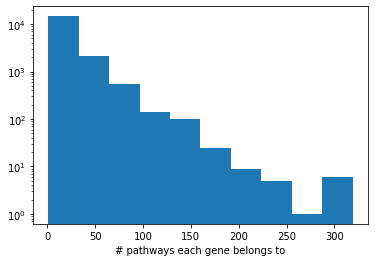

In [8]:
plt.hist(np.sum(membership_p_by_g,axis=0), log=True);
plt.xlabel("# pathways each gene belongs to")

### Calculate overlapping size

In [9]:
overlap_size = np.zeros([len(pathways_df), len(pathways_df)])

for i,pway1 in pathways_df.iterrows():
    
    if i%10==0:
        print("%i of %i"%(i, len(pathways_df)))
    
    for j,pway2 in pathways_df.iterrows():
        if i > j:
            overlap_size[i,j] = overlap_size[j,i]

        else:
            
            overlap_size[i,j] = len(np.intersect1d(pway1["genes"],pway2["genes"]))



0 of 4847
10 of 4847
20 of 4847
30 of 4847
40 of 4847
50 of 4847
60 of 4847
70 of 4847
80 of 4847
90 of 4847
100 of 4847
110 of 4847
120 of 4847
130 of 4847
140 of 4847
150 of 4847
160 of 4847
170 of 4847
180 of 4847
190 of 4847
200 of 4847
210 of 4847
220 of 4847
230 of 4847
240 of 4847
250 of 4847
260 of 4847
270 of 4847
280 of 4847
290 of 4847
300 of 4847
310 of 4847
320 of 4847
330 of 4847
340 of 4847
350 of 4847
360 of 4847
370 of 4847
380 of 4847
390 of 4847
400 of 4847
410 of 4847
420 of 4847
430 of 4847
440 of 4847
450 of 4847
460 of 4847
470 of 4847
480 of 4847
490 of 4847
500 of 4847
510 of 4847
520 of 4847
530 of 4847
540 of 4847
550 of 4847
560 of 4847
570 of 4847
580 of 4847
590 of 4847
600 of 4847
610 of 4847
620 of 4847
630 of 4847
640 of 4847
650 of 4847
660 of 4847
670 of 4847
680 of 4847
690 of 4847
700 of 4847
710 of 4847
720 of 4847
730 of 4847
740 of 4847
750 of 4847
760 of 4847
770 of 4847
780 of 4847
790 of 4847
800 of 4847
810 of 4847
820 of 4847
830 of 4847
840

In [10]:
# overlap_fracs_toplot:
# [i, j] --> fraction of pathway i's genes that are also in pathway j

pway_sizes = np.array([len(x) for x in pathways_df["genes"]])
overlap_size_toplot = copy.copy(overlap_size)

for i in range(len(overlap_size_toplot)): 
    overlap_size_toplot[i,i] = 0
overlap_fracs_toplot = (overlap_size_toplot/pway_sizes).T


In [11]:
pathways_df["source"].value_counts()

c5.mf.v7.0.symbols           1645
c5.bp.v7.0.symbols_SHORT     1517
c2.all.v7.0.symbols_JustR    1499
c2.all.v7.0.symbols_JustK     186
Name: source, dtype: int64

In [12]:
combined_idxes = {}
for pway_subfolder in pway_subfolders:
    combined_idxes[pway_subfolder] = np.array(pathways_df[pathways_df["source"]==pway_subfolder].index)

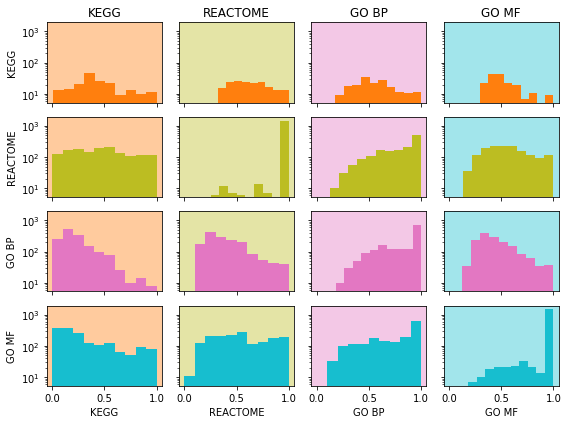

In [13]:
cross_database_max_overlaps = {}
f,ax = plt.subplots(len(pway_subfolders), len(pway_subfolders), figsize=(8,6), sharex=True, sharey=True)
for d_i, d1 in enumerate(pway_subfolders):
    cross_database_max_overlaps[d1] = []
    for d_j, d2 in enumerate(pway_subfolders):
        tmp = overlap_fracs_toplot[combined_idxes[d1]][:, combined_idxes[d2]]
        max_overlap_fractions = np.max(tmp,axis=1)

        if d_i==d_j:
            for i in range(len(tmp)):
                tmp[i,i]=0
        else:
            cross_database_max_overlaps[d1].append(max_overlap_fractions)
            
        ax[d_i, d_j].hist(max_overlap_fractions, log=True, color=database_colors[d1])
        ax[d_i, d_j].patch.set_facecolor(database_colors[d2])
        ax[d_i, d_j].patch.set_alpha(0.4)
        
        if d_j==0:
            ax[d_i,d_j].set_ylabel(database_names[d1])
        if d_i==len(pway_subfolders)-1:
            ax[d_i,d_j].set_xlabel(database_names[d2])
        if d_i==0:
            ax[d_i,d_j].set_title(database_names[d2])
            
        ax[d_i, d_j].tick_params(axis='both', which='major', labelsize=10)
        
    f.tight_layout()




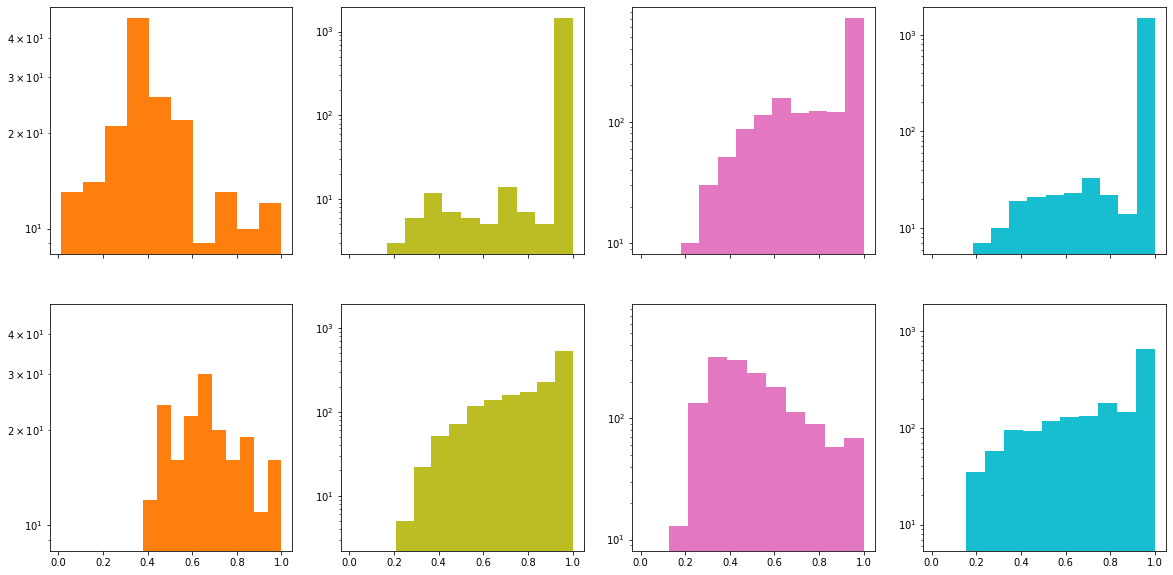

In [14]:
highest_other_databases_all = []
f,ax = plt.subplots(2, len(pway_subfolders), figsize=(20,10), sharex=True, sharey="col")
for d_i, d1 in enumerate(pway_subfolders):
    cross_database_max_overlaps = []
    for d_j, d2 in enumerate(pway_subfolders):
        tmp = overlap_fracs_toplot[combined_idxes[d1]][:, combined_idxes[d2]]
        max_overlap_fractions = np.max(tmp,axis=1)

        if d_i==d_j:
            for i in range(len(tmp)):
                tmp[i,i]=0
            ax[0, d_i].hist(max_overlap_fractions, log=True, color=database_colors[d1])

        else:
            cross_database_max_overlaps.append(max_overlap_fractions)
            
        ax[0, d_i].tick_params(axis='both', which='major', labelsize=10)
        
    highest_other_databases = np.max(np.vstack(cross_database_max_overlaps),axis=0)
    highest_other_databases_all.append(highest_other_databases)
    ax[1,d_i].hist(highest_other_databases, log=True, color=database_colors[d1])
    ax[1, d_i].tick_params(axis='both', which='major', labelsize=10)
 

### Calculations to include in paper

In [15]:
print("50%% of pathways have a corresponding pathway in another database with at least %.1f%% overlap"%
      np.median(np.hstack(highest_other_databases_all)*100))

50% of pathways have a corresponding pathway in another database with at least 70.4% overlap


In [17]:
# oxidative phosphorylation example:

pway_query = "KEGG_OXIDATIVE_PHOSPHORYLATION"
query_i = pathways_df[pathways_df["names"]==pway_query].index[0]
query_overlaps = overlap_fracs_toplot[query_i]
print("TOP OVERLAPPING PATHWAYS WITH %s:"%pway_query)
for i in np.argsort(query_overlaps)[::-1][:10]:
    print("%s:  %.1f%%"%(pathways_df["names"][i], query_overlaps[i]*100))

TOP OVERLAPPING PATHWAYS WITH KEGG_OXIDATIVE_PHOSPHORYLATION:
KEGG_PARKINSONS_DISEASE:  71.0%
REACTOME_THE_CITRIC_ACID_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TRANSPORT:  65.6%
KEGG_HUNTINGTONS_DISEASE:  65.6%
KEGG_ALZHEIMERS_DISEASE:  65.6%
REACTOME_RESPIRATORY_ELECTRON_TRANSPORT_ATP_SYNTHESIS_BY_CHEMIOSMOTIC_COUPLING_AND_HEAT_PRODUCTION_BY_UNCOUPLING_PROTEINS:  65.6%
GO_OXIDOREDUCTASE_ACTIVITY:  59.5%
GO_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN:  56.5%
GO_CELLULAR_RESPIRATION:  56.5%
GO_CATION_TRANSPORT:  56.5%
GO_ION_TRANSMEMBRANE_TRANSPORT:  55.7%
